## Read File

In [86]:
"test"

'test'

In [87]:
import pandas as pd

# CCBA_PATH = '../dataset/train_first/public_train_x_ccba_full_hashed.csv'
# CDTX_PATH = '../dataset/train_first/public_train_x_cdtx0001_full_hashed.csv'
# DP_PATH = '../dataset/train_first/public_train_x_dp_full_hashed.csv'
# REMIT_PATH = '../dataset/train_first/public_train_x_remit1_full_hashed.csv'
CUSTINFO_PATH = 'dataset/train_first/public_train_x_custinfo_full_hashed.csv'
PDATE_PATH = 'dataset/train_first/public_x_alert_date.csv'
TDATE_PATH = 'dataset/train_first/train_x_alert_date.csv'
ANSWER_PATH = 'dataset/train_first/train_y_answer.csv'
SAMPLE_PATH = 'dataset/train_first/sample_submission.csv'

# ccba = pd.read_csv(CCBA_PATH)
# cdtx = pd.read_csv(CDTX_PATH)
# dp = pd.read_csv(DP_PATH)
# remit = pd.read_csv(REMIT_PATH)
cinfo = pd.read_csv(CUSTINFO_PATH)
pdate = pd.read_csv(PDATE_PATH)
tdate = pd.read_csv(TDATE_PATH)
answer = pd.read_csv(ANSWER_PATH)
sample = pd.read_csv(SAMPLE_PATH)

In [88]:
pdate.head()

,alert_key,date
0,352342,365
1,352866,365
2,352696,365
3,352330,365
4,352683,365


In [89]:
# add data label
# pdate > public_x_alert_date is a test dataset
# tdate > train_x_alert_date is a train dataset
pdate.insert(pdate.shape[1], "data_label", ["test"] * pdate.shape[0], True)
tdate.insert(tdate.shape[1], "data_label", ["train"] * tdate.shape[0], True)
date = pd.concat([pdate, tdate], axis=0)
date.head()

,alert_key,date,data_label
0,352342,365,test
1,352866,365,test
2,352696,365,test
3,352330,365,test
4,352683,365,test


In [90]:
# check if the public date and sample submission is the same key
sample[sample['alert_key'].isin(pdate['alert_key'])]

,alert_key,probability
0,357307,0.000017
3,357668,0.000489
4,354443,0.000526
5,361128,0.000887
6,364753,0.001057
...,...,...
3842,357676,0.996705
3844,360534,0.997549
3845,364485,0.997702
3846,363155,0.998987


## Preprocess

In [91]:
import pandas as pd

In [92]:
# Map Date and target to 'cust_info'
cinfo = cinfo.merge(date, on='alert_key', how='left')
cinfo = cinfo.merge(answer, on='alert_key', how='left')

In [93]:
cinfo.head()

,alert_key,cust_id,risk_rank,occupation_code,total_asset,AGE,date,data_label,sar_flag
0,352249,82595ac69158ae08d34156784bdec0d9e2ca5b242b6d2a...,1,19.0,1465816.0,7,365,test,NaN
1,352253,b212d14cb35676926682b2cf849e295d948888f556c07e...,1,2.0,98177.0,2,365,test,NaN
2,352254,e5b0002791c7852644a2730abeaa893cdf14a072ef7812...,1,19.0,2052922.0,7,365,test,NaN
3,352280,74214c478dc6519fbefe4bc31693865bdcd698ab974b64...,3,15.0,201906.0,5,365,test,NaN
4,352282,0340e7611f0d82c3cb87e6194fa14bb2ccf8afbf1b3418...,1,12.0,7450.0,5,365,test,NaN


In [94]:
import copy

# separate
train_cinfo = copy.deepcopy(cinfo)
train_cinfo = train_cinfo[~pd.isna(train_cinfo['sar_flag'])]
train_cinfo.head()

,alert_key,cust_id,risk_rank,occupation_code,total_asset,AGE,date,data_label,sar_flag
1845,171142,a39fea9aec90969fe66a2b2b4d1b86368a2d38e8b8d4bf...,3,12.0,241719.0,3,0,train,0.0
1846,171152,7e42b5dca9b28ee8e5545beb834361e90e6197d176b389...,3,13.0,599497.0,6,0,train,0.0
1847,171177,a6cdf6302aead77112013168c6d546d2df3bcb551956d2...,1,19.0,51160.0,4,0,train,0.0
1848,171178,1a3efa69705f611c7ef2384a715c8142e2ee801cfec9df...,3,9.0,3634343.0,6,0,train,0.0
1849,171180,67f8cbb64dd3d447e992b1b299e0ceed3372188e47c88e...,1,17.0,4076287.0,4,0,train,0.0


In [95]:
mean_encoding_map = {}

def mean_encoding(key):
    key_map = {}
    keys = pd.unique(train_cinfo[key])  #[k for k in pd.unique(X_under[key]) if not (pd.isna(k))]
    for k in keys:
        if pd.isna(k):
            key_map[k] = 0
            continue
        is_sar_num = len((train_cinfo[(train_cinfo['sar_flag'] == 1.0) & (train_cinfo[key] == k)]))
        total_num = len(train_cinfo[train_cinfo[key] == k])
        mean_val = is_sar_num / total_num * 100
        key_map[k] = mean_val
    mean_encoding_map[key] = key_map


mean_encoding('AGE')
mean_encoding('risk_rank')
mean_encoding('date')
mean_encoding('occupation_code')
mean_encoding_map['date'][365] = 0
mean_encoding_map

{'AGE': {3: 1.1390728476821192,
  6: 0.5569306930693069,
  4: 0.8374384236453201,
  5: 0.7261724659606656,
  2: 1.2917115177610334,
  9: 0.0,
  1: 1.1363636363636365,
  7: 0.22522522522522523,
  8: 2.3529411764705883,
  10: 0.0,
  0: 0.0},
 'risk_rank': {3: 0.21413276231263384,
  1: 1.2931842318985445,
  2: 1.4423076923076923,
  0: 0.0},
 'date': {0: 1.1363636363636365,
  5: 0.6578947368421052,
  6: 0.0,
  7: 1.2048192771084338,
  8: 0.0,
  11: 0.0,
  12: 2.380952380952381,
  13: 0.4878048780487805,
  14: 2.127659574468085,
  15: 0.0,
  18: 0.9900990099009901,
  19: 1.1494252873563218,
  20: 0.0,
  21: 1.3157894736842104,
  22: 0.0,
  25: 0.847457627118644,
  26: 4.477611940298507,
  27: 2.197802197802198,
  28: 1.1627906976744187,
  32: 2.2058823529411766,
  33: 1.2987012987012987,
  34: 1.098901098901099,
  35: 1.2658227848101267,
  36: 3.7037037037037033,
  39: 1.8518518518518516,
  40: 1.2658227848101267,
  41: 3.7037037037037033,
  42: 2.197802197802198,
  43: 5.747126436781609,
 

In [96]:
for k, v in mean_encoding_map.items():
    mean_encoding_val = [0 if pd.isna(x) or v.get(x) is None else v[x] for x in cinfo[k]]
    column_name = k + "_encoding"
    cinfo = pd.concat([cinfo, pd.DataFrame({column_name: mean_encoding_val})], axis=1)

cinfo.head()

,alert_key,cust_id,risk_rank,occupation_code,total_asset,AGE,date,data_label,sar_flag,AGE_encoding,risk_rank_encoding,date_encoding,occupation_code_encoding
0,352249,82595ac69158ae08d34156784bdec0d9e2ca5b242b6d2a...,1,19.0,1465816.0,7,365,test,NaN,0.225225,1.293184,0.0,0.941968
1,352253,b212d14cb35676926682b2cf849e295d948888f556c07e...,1,2.0,98177.0,2,365,test,NaN,1.291712,1.293184,0.0,1.282051
2,352254,e5b0002791c7852644a2730abeaa893cdf14a072ef7812...,1,19.0,2052922.0,7,365,test,NaN,0.225225,1.293184,0.0,0.941968
3,352280,74214c478dc6519fbefe4bc31693865bdcd698ab974b64...,3,15.0,201906.0,5,365,test,NaN,0.726172,0.214133,0.0,1.521739
4,352282,0340e7611f0d82c3cb87e6194fa14bb2ccf8afbf1b3418...,1,12.0,7450.0,5,365,test,NaN,0.726172,1.293184,0.0,0.758534


In [97]:
X = cinfo[cinfo['data_label'] == 'train']
len(X)

23906

In [98]:
test = cinfo[cinfo['data_label'] == 'test']
len(test)

1845

In [99]:
test_alert_keys = test['alert_key']
test_alert_keys.head()

0    352249
1    352253
2    352254
3    352280
4    352282
Name: alert_key, dtype: int64

In [100]:
test.head()

,alert_key,cust_id,risk_rank,occupation_code,total_asset,AGE,date,data_label,sar_flag,AGE_encoding,risk_rank_encoding,date_encoding,occupation_code_encoding
0,352249,82595ac69158ae08d34156784bdec0d9e2ca5b242b6d2a...,1,19.0,1465816.0,7,365,test,NaN,0.225225,1.293184,0.0,0.941968
1,352253,b212d14cb35676926682b2cf849e295d948888f556c07e...,1,2.0,98177.0,2,365,test,NaN,1.291712,1.293184,0.0,1.282051
2,352254,e5b0002791c7852644a2730abeaa893cdf14a072ef7812...,1,19.0,2052922.0,7,365,test,NaN,0.225225,1.293184,0.0,0.941968
3,352280,74214c478dc6519fbefe4bc31693865bdcd698ab974b64...,3,15.0,201906.0,5,365,test,NaN,0.726172,0.214133,0.0,1.521739
4,352282,0340e7611f0d82c3cb87e6194fa14bb2ccf8afbf1b3418...,1,12.0,7450.0,5,365,test,NaN,0.726172,1.293184,0.0,0.758534


### Drop confusing customer id
1. get all alert flag where customer id is sar
2. remove all data where cust_id is in sar for non-sar record

In [141]:
sar_cust = X[X['sar_flag'] == 1]
sar_cust.head()

,alert_key,cust_id,risk_rank,occupation_code,total_asset,AGE,date,data_label,sar_flag,AGE_encoding,risk_rank_encoding,date_encoding,occupation_code_encoding
1926,171770,25cf26d9c40bb9f71292b809c4f92018b9bdfe3529c510...,1,17.0,1913895.0,4,0,train,1.0,0.837438,1.293184,1.136364,1.062135
2026,172480,7fde997da7e7a95280460889004bd2f23050bd8953de7e...,3,12.0,8251.0,4,5,train,1.0,0.837438,0.214133,0.657895,0.758534
2281,174298,bf19e3fe441d8dfa31794de3b4c318770ca7da5b4f5973...,1,19.0,186714.0,7,7,train,1.0,0.225225,1.293184,1.204819,0.941968
3443,177788,6400e6bb0fea2dc8410931f6eaf99e9513e4c025f9c9c2...,1,15.0,1744729.0,5,12,train,1.0,0.726172,1.293184,2.380952,1.521739
3479,177960,26eeff4dcdbf9ddb3e2628f8710a1e87b1ea53d37e0331...,1,9.0,238193.0,2,12,train,1.0,1.291712,1.293184,2.380952,0.563014


In [142]:
X = X[~X['cust_id'].isin(sar_cust.cust_id.tolist())]
X.shape

(23019, 13)

In [143]:
X = pd.concat([X, sar_cust])
X.head()

,alert_key,cust_id,risk_rank,occupation_code,total_asset,AGE,date,data_label,sar_flag,AGE_encoding,risk_rank_encoding,date_encoding,occupation_code_encoding
1845,171142,a39fea9aec90969fe66a2b2b4d1b86368a2d38e8b8d4bf...,3,12.0,241719.0,3,0,train,0.0,1.139073,0.214133,1.136364,0.758534
1846,171152,7e42b5dca9b28ee8e5545beb834361e90e6197d176b389...,3,13.0,599497.0,6,0,train,0.0,0.556931,0.214133,1.136364,1.693002
1847,171177,a6cdf6302aead77112013168c6d546d2df3bcb551956d2...,1,19.0,51160.0,4,0,train,0.0,0.837438,1.293184,1.136364,0.941968
1848,171178,1a3efa69705f611c7ef2384a715c8142e2ee801cfec9df...,3,9.0,3634343.0,6,0,train,0.0,0.556931,0.214133,1.136364,0.563014
1849,171180,67f8cbb64dd3d447e992b1b299e0ceed3372188e47c88e...,1,17.0,4076287.0,4,0,train,0.0,0.837438,1.293184,1.136364,1.062135


In [150]:
y = X['sar_flag']
y.shape

(23253,)

## Deal with imbalance problem
-  Over sampling
-  Under sampling

### Training XGBoost - Over sampling

In [153]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()

X_smote_prep = copy.deepcopy(X)
X_smote_prep = X_smote_prep.dropna()
X_smote_prep = X_smote_prep.drop(['cust_id', 'data_label'], axis=1)
y_smote_prep = X_smote_prep['sar_flag']
X_smote, y_smote = smote.fit_resample(X_smote_prep, y_smote_prep)
X_smote.shape
X_smote[X_smote['sar_flag'] == 1.0].shape, X_smote[X_smote['sar_flag'] == 0.0].shape

((22903, 11), (22903, 11))

In [154]:
import xgboost as xgb
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, test_size=0.4,
                                                                            random_state=123)
X_train_smote.head()

,alert_key,risk_rank,occupation_code,total_asset,AGE,date,sar_flag,AGE_encoding,risk_rank_encoding,date_encoding,occupation_code_encoding
20012,328400,1,12.000000,500199.000000,2,323,0.0,1.291712,1.293184,0.000000,0.758534
13971,283603,1,13.000000,0.000000,3,244,0.0,1.139073,1.293184,0.943396,1.693002
40819,222065,1,13.095274,36525.538824,4,114,1.0,0.895267,1.381238,4.017190,0.718206
43705,235989,1,12.379936,5127.850908,3,145,1.0,0.941916,1.293184,2.124527,2.250822
20733,334830,1,7.000000,0.000000,5,335,0.0,0.726172,1.293184,0.000000,0.000000


In [155]:
import seaborn as sns
from sklearn.metrics import accuracy_score

In [156]:
drop_features_smote = ["alert_key", "sar_flag"]
X_train_smote = X_train_smote.drop(drop_features_smote, axis=1)
X_test_smote = X_test_smote.drop(drop_features_smote, axis=1)

(0.9938874638432571,
 array([[8959,   27],
        [  85, 9252]]))

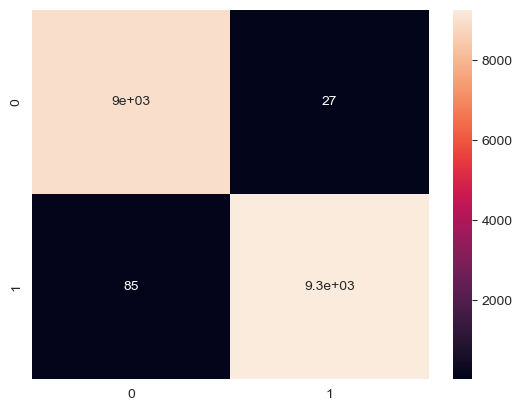

In [157]:
xg_cls_smote = xgb.XGBClassifier()
xg_cls_smote.fit(X_train_smote, y_train_smote)

cls_preds_smote = xg_cls_smote.predict(X_test_smote)

cm_smote = confusion_matrix(y_test_smote, cls_preds_smote)
sns.heatmap(cm_smote, annot=True)

accuracy_score(y_test_smote, cls_preds_smote), cm_smote

### Training XGBoost - Under sampling

In [158]:
from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler()
X_under, y_under = undersample.fit_resample(X, y)

In [159]:
X_under

,alert_key,cust_id,risk_rank,occupation_code,total_asset,AGE,date,data_label,sar_flag,AGE_encoding,risk_rank_encoding,date_encoding,occupation_code_encoding
0,202242,ecb3475f0ba47929aec4d23e9a68b432bcf44599d1ad39...,1,17.0,27182.0,7,69,train,0.0,0.225225,1.293184,1.666667,1.062135
1,276541,395ad956007ff1190d024dc1811bde0f544c86e7bf41a8...,3,12.0,665448.0,4,230,train,0.0,0.837438,0.214133,0.000000,0.758534
2,336757,81fa0100bc5af8787771dfeb412d5a0b619a3c58e6f0d4...,1,13.0,138183.0,5,326,train,0.0,0.726172,1.293184,0.000000,1.693002
3,241305,10a082d613a789acd3abc2648c84585e92e93d7fa20591...,3,15.0,101105.0,4,155,train,0.0,0.837438,0.214133,0.000000,1.521739
4,217895,4918ef8c57ddbbba9b7695cd75855d042cf60b718a5e89...,1,19.0,445363.0,4,105,train,0.0,0.837438,1.293184,3.174603,0.941968
...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,346021,9efb72c106f786e5a99a8c2b245864c831cf008dd2e9ee...,1,13.0,310.0,3,351,train,1.0,1.139073,1.293184,1.098901,1.693002
464,347051,a21eeb4acc2c9c128403c88c3f3e248bcf20067059d33b...,2,11.0,258763.0,3,355,train,1.0,1.139073,1.442308,1.265823,2.605863
465,347894,9a1d940986fce29cd6b54d5a5fe076a5aa8026161f5627...,1,17.0,337845.0,5,356,train,1.0,0.726172,1.293184,1.470588,1.062135
466,348724,2f4011af820fb0a91313221c6cc2b649495a5cb05aed82...,1,19.0,2439013.0,2,358,train,1.0,1.291712,1.293184,1.176471,0.941968


In [160]:
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.2, random_state=123)

In [161]:
test

,risk_rank,occupation_code,total_asset,AGE,date,AGE_encoding,risk_rank_encoding
0,1,19.0,1465816.0,7,365,0.225225,1.293184
1,1,2.0,98177.0,2,365,1.291712,1.293184
2,1,19.0,2052922.0,7,365,0.225225,1.293184
3,3,15.0,201906.0,5,365,0.726172,0.214133
4,1,12.0,7450.0,5,365,0.726172,1.293184
...,...,...,...,...,...,...,...
1840,1,17.0,135072.0,3,393,1.139073,1.293184
1841,3,12.0,2285386.0,3,393,1.139073,0.214133
1842,3,19.0,1230244.0,2,393,1.291712,0.214133
1843,1,17.0,162418.0,2,393,1.291712,1.293184


In [151]:
drop_features = ["alert_key", "cust_id", "data_label", "sar_flag", "date_encoding", "occupation_code_encoding"]
X_train = X_train.drop(drop_features, axis=1)
X_test = X_test.drop(drop_features, axis=1)
test = test.drop(drop_features, axis=1)

KeyError: "['alert_key', 'cust_id', 'data_label', 'sar_flag', 'date_encoding', 'occupation_code_encoding'] not found in axis"

In [140]:
X_train

,risk_rank,occupation_code,total_asset,AGE,date,AGE_encoding,risk_rank_encoding
148,1,5.0,136103.0,2,95,1.291712,1.293184
131,1,17.0,732084.0,3,252,1.139073,1.293184
437,1,17.0,72355.0,3,245,1.139073,1.293184
317,3,18.0,867571.0,3,71,1.139073,0.214133
400,3,18.0,84616.0,3,174,1.139073,0.214133
...,...,...,...,...,...,...,...
230,3,13.0,107990.0,4,272,0.837438,0.214133
98,1,19.0,0.0,3,257,1.139073,1.293184
322,1,18.0,484391.0,2,75,1.291712,1.293184
382,1,11.0,6014.0,4,144,0.837438,1.293184


In [115]:
xg_cls = xgb.XGBClassifier()
xg_cls.fit(X_train, y_train)

cls_preds = xg_cls.predict(X_test)

In [4]:
import pandas as pd
pd.__version__

'1.5.1'

0.776595744680851

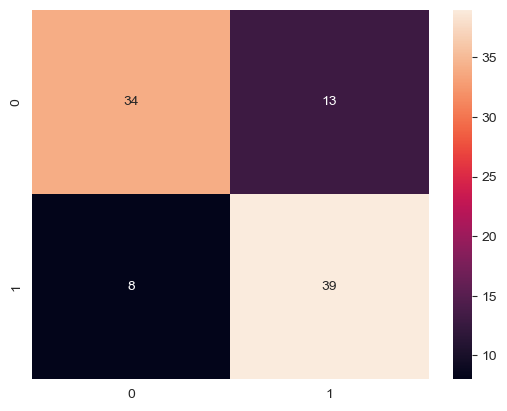

In [116]:
import seaborn as sns
from sklearn.metrics import accuracy_score

cm = confusion_matrix(y_test, cls_preds)
sns.heatmap(cm, annot=True)
accuracy_score(y_test, cls_preds)

In [117]:
prob_test = [prob[1] for prob in xg_cls.predict_proba(test).tolist()]
prob_test[:10]

[0.07682039588689804,
 0.4635014533996582,
 0.064445860683918,
 0.01227553654462099,
 0.015841010957956314,
 0.2426479011774063,
 0.0038429545238614082,
 0.17124995589256287,
 0.273330956697464,
 0.009257550351321697]

In [118]:
non_predicted_key = sample[~sample['alert_key'].isin(test_alert_keys)]
non_predicted_key = non_predicted_key.assign(probability=0)
non_predicted_key.shape

(2005, 2)

In [119]:
submission = pd.concat([test_alert_keys, pd.DataFrame({'probability': prob_test})], axis=1)
submission = submission.sort_values(by=['probability'], ascending=False)
submission = pd.concat([submission, non_predicted_key])
submission.shape, submission.head()

((3850, 2),
       alert_key  probability
 301      354810     0.958726
 461      355759     0.958726
 1521     362855     0.933158
 1745     364454     0.933158
 1833     364983     0.931260)

In [120]:
submission.to_csv("submission_xgboost.csv", index=False)